## Setup

In [ ]:
%load_ext autoreload
%autoreload 2

## Install packages

In [ ]:
! pip install terratorch==1.0.1 gdown tensorboard

In [ ]:
# Run this line if you are using Google Colab
# ! wget https://raw.githubusercontent.com/oroikono/IBM-BlueSky-Challenge-ZeroFlood/main/dataset.py
# ! wget https://raw.githubusercontent.com/oroikono/IBM-BlueSky-Challenge-ZeroFlood/main/model.py
# ! wget https://raw.githubusercontent.com/oroikono/IBM-BlueSky-Challenge-ZeroFlood/main/tools.py

## Import modules

In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

from dataset import FloodDataModule
from model import FloodRiskModel

## Download dataset

In [2]:
! git lfs install
! git clone https://huggingface.co/datasets/hk-kaden-kim/BlueSky-Challenge-Dataset

Git LFS initialized.
Cloning into 'BlueSky-Challenge-Dataset'...
remote: Enumerating objects: 13271, done.
remote: Total 13271 (delta 0), reused 0 (delta 0), pack-reused 13271 (from 1)
Receiving objects: 100% (13271/13271), 7.92 MiB | 15.27 MiB/s, done.
Resolving deltas: 100% (6003/6003), done.
Updating files: 100% (13297/13297), done.
Filtering content: 100% (6645/6645), 2.31 GiB | 16.30 MiB/s, done.


In [3]:
# Dataset statistics
DATASET_DIR = "BlueSky-Challenge-Dataset"
for split in ["train", "test", "val"]:
  png_files_cnt = 0
  csv_files_cnt = 0
  for root, dirs, files in os.walk(os.path.join(DATASET_DIR, split)):
      for file in files:
          if file.endswith('.png'):
              png_files_cnt += 1
          if file.endswith('.csv'):
              csv_files_cnt += 1
  print(f"{split}: {png_files_cnt} images and {csv_files_cnt} masks")

train: 3184 images and 3184 masks
test: 1332 images and 1332 masks
val: 2128 images and 2128 masks


## Download Model

In [4]:
! mkdir ./BlueSky-Challenge-Model
! wget "https://huggingface.co/oroikon/IBM-BlueSky-Challenge-ZeroFlood/resolve/main/all.ckpt" -P ./BlueSky-Challenge-Model

--2025-07-03 01:20:54--  https://huggingface.co/oroikon/IBM-BlueSky-Challenge-ZeroFlood/resolve/main/all.ckpt
Resolving huggingface.co (huggingface.co)... 3.163.189.114, 3.163.189.74, 3.163.189.90, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.114|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/8e/04/8e04977d0fc069019ee5bf7403d0f6d1264a6ee9ccc4e93fcf8701ada15d1c16/729a0635cae76eaad7111d95aa2c147985e482032201b75d773ee8a272e788c4?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27all.ckpt%3B+filename%3D%22all.ckpt%22%3B&Expires=1751509254&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc1MTUwOTI1NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzhlLzA0LzhlMDQ5NzdkMGZjMDY5MDE5ZWU1YmY3NDAzZDBmNmQxMjY0YTZlZTljY2M0ZTkzZmNmODcwMWFkYTE1ZDFjMTYvNzI5YTA2MzVjYWU3NmVhYWQ3MTExZDk1YWEyYzE0Nzk4NWU0ODIwMzIyMDFiNzVkNzczZWU4YTI3MmU3ODhjND9yZXNwb25zZS1jb250ZW50L

# Inference

In [5]:
BATCH_SIZE = 4
CHECKPOINT = "./BlueSky-Challenge-Model/all.ckpt"
TiM = [
    "S1RTC",
    "DEM",
    "LULC",
    "NDVI",
    ]


In [6]:
# Initialize datamodule
datamodule = FloodDataModule(
    local_path=DATASET_DIR,
    batch_size=BATCH_SIZE,  # Adjust based on GPU memory
    num_workers=8
)
datamodule.setup("test")
sample = datamodule.test_dataset[0]

print(f"\nDataset Summary:")
print(f"Test samples: {len(datamodule.test_dataset)}")
print(f"Sample keys: {sample.keys()}")
print(f"Image shape: {sample['image'].shape}")
print(f"Mask shape: {sample['mask'].shape}")
print(f"Mask unique values: {torch.unique(sample['mask'])}")
print()

Validation samples: 1332

Dataset Summary:
Test samples: 1332
Sample keys: dict_keys(['image', 'mask'])
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Mask unique values: tensor([0, 1])



In [7]:
# Initialize model
model = FloodRiskModel.load_from_checkpoint(CHECKPOINT, tim=TiM)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
_ = model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


TerraMind_v1_base.pt:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

In [8]:
# Inference
all_results = []
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(datamodule.test_dataloader())):

        imgs = batch['image'].to(device)
        logits = model(imgs).output

        probs = torch.softmax(logits, dim=1)
        confs = probs[:,1].cpu().numpy()

        pred_masks = torch.argmax(probs, dim=1).cpu()
        true_masks = batch['mask']

        # compute the starting index for this batch
        base_idx = batch_idx * datamodule.batch_size

        for i in range(imgs.size(0)):

            sample_idx = base_idx + i
            img_path   = datamodule.test_dataset.samples[sample_idx][0]

            pred_flatten  = pred_masks[i].numpy().flatten()
            true_flatten = true_masks[i].numpy().flatten()

            all_results.append({
                'image_path':     img_path,
                'accuracy':       accuracy_score(true_flatten, pred_flatten),
                'iou':            jaccard_score(true_flatten, pred_flatten, average='binary'),
                'f1':             f1_score(true_flatten, pred_flatten, average='binary'),
                'flood_pct_pred': pred_flatten.sum() / pred_flatten.size * 100,
                'flood_pct_gt':   true_flatten.sum() / true_flatten.size * 100,
                'flood_mask':     pred_masks[i].numpy(),
                'confidence':     confs[i]
            })

print(f"Tested {len(all_results)} samples.")
print(f"Mean Acc: {np.mean([r['accuracy'] for r in all_results]):.3f}")
print(f"Mean IoU: {np.mean([r['iou']     for r in all_results]):.3f}")
print(f"Mean F1:  {np.mean([r['f1']      for r in all_results]):.3f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 333/333 [10:39<00:00,  1.92s/it]

Tested 1332 samples.
Mean Acc: 0.684
Mean IoU: 0.305
Mean F1:  0.409


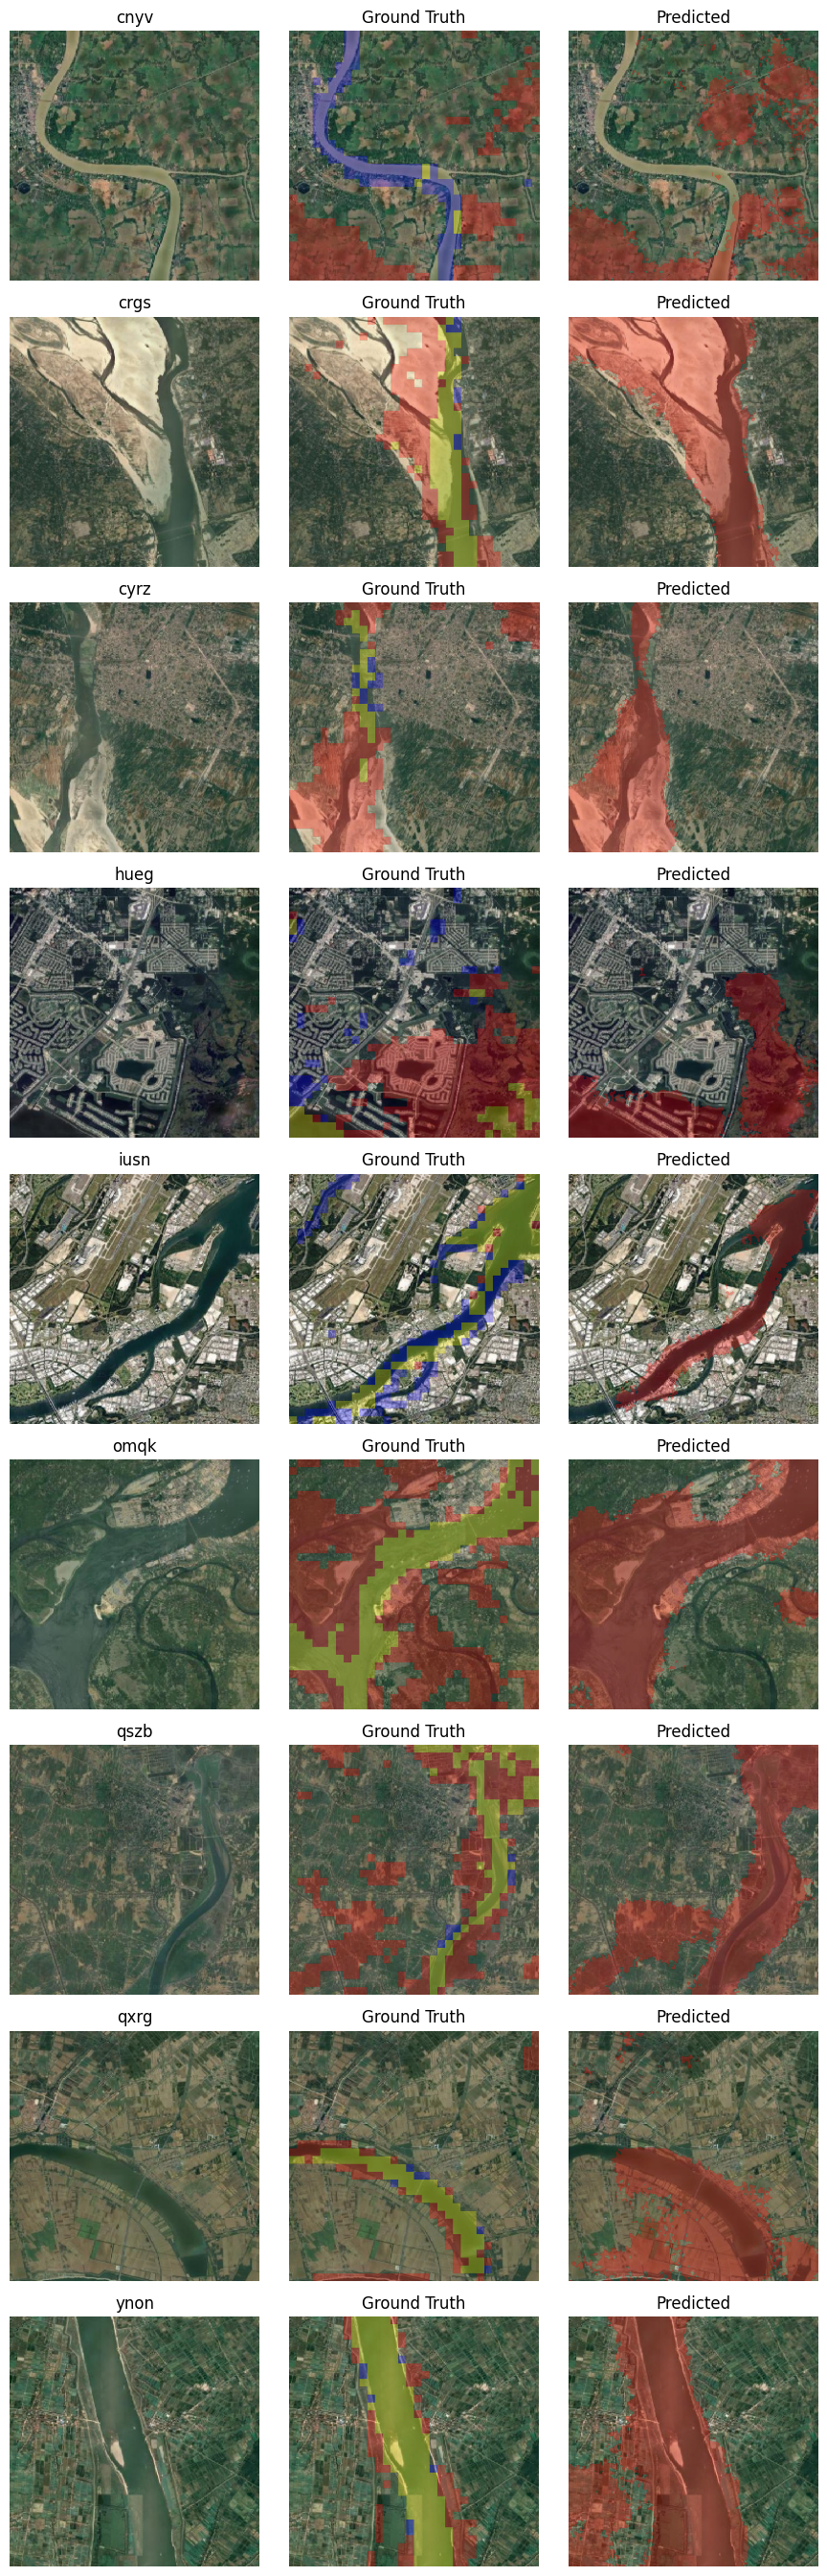

In [9]:
TEST_SAMPLES = ['cnyv', 'crgs', 'cyrz', 'hueg', 'iusn', 'omqk', 'qszb', 'qxrg', 'ynon']

# Create subplots
rows = len(TEST_SAMPLES)
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
if rows == 1:
    axes = [axes]

zone_id_all = [r['image_path'].name for r in all_results]
for i, zone_id in enumerate(TEST_SAMPLES):

  idx = zone_id_all.index(zone_id+'.png')

  # Prediction - Flood Risky Zone
  pred_arr = all_results[idx]['flood_mask']
  pred_rgba = np.zeros((*pred_arr.shape, 4), dtype=np.float32)
  pred_rgba[pred_arr == 1] = [1, 0, 0, 0.3]     # Red

  # Satellite RGB Imagery
  img_path = str(all_results[idx]['image_path'])
  image = Image.open(img_path).convert('RGB')
  image_resized = image.resize((pred_arr.shape[1], pred_arr.shape[0]), Image.NEAREST)
  image_resized = np.array(image_resized)

  # Ground Truth - Flood / Water Body / Water & Flood
  mask_path = img_path.replace('image','mask').replace('png','csv')
  mask_arr = pd.read_csv(mask_path,header=None).to_numpy()
  K = int(pred_arr.shape[0]/ mask_arr.shape[0])
  mask_arr = mask_arr.repeat(K, axis=0).repeat(K, axis=1)
  mask_rgba = np.zeros((*mask_arr.shape, 4), dtype=np.float32)
  mask_rgba[mask_arr == 1] = [1, 0, 0, 0.3]     # Red
  mask_rgba[mask_arr == 2] = [0, 0, 1, 0.3]     # Blue
  mask_rgba[mask_arr == 3] = [1, 1, 0, 0.3]     # Yellow

  # Plot
  axes[i][0].imshow(image_resized)
  axes[i][0].set_title(f"{zone_id}")
  axes[i][0].axis('off')

  axes[i][1].imshow(image_resized)
  axes[i][1].imshow(mask_rgba)
  axes[i][1].set_title(f'Ground Truth')
  axes[i][1].axis('off')

  axes[i][2].imshow(image_resized)
  axes[i][2].imshow(pred_rgba)
  axes[i][2].set_title(f'Predicted')
  axes[i][2].axis('off')

plt.tight_layout()
plt.show()


